# Семинар 13. Эмбеддинги слов. Skip-gram Word2Vec

Source: https://github.com/hse-ds/iad-deep-learning/tree/master/2021/seminars/sem07

* Полезный [общий взгляд](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) на Word2Vec
* [Первые работы с Word2Vec](https://arxiv.org/pdf/1301.3781.pdf) 
* [Neural Information Processing Systems, paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) с улучшениями Word2Vec 

---
## Word embeddings

Для задач обработки текстов, в которых анализируемой единицей являются слова (part of speech tagging, named entity recognition, генерация текста, etc.) бывает полезно пользоваться готовыми признаковыми описаниями слов, заранее обученными за нас.
Такие признаковые описания обычно обучают в форме векторов и называют эмбеддингами.
Далее, при решении конкретной задачи, слова в текстах заменяют обученные эмбеддинги и поверх этого дела уже строят разные модели.

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/word2vec-embeddings/assets/one_hot_encoding.png?raw=1' width=50%>

Конечно же, как мы это делали в предыдущем курсе, можно, использовать one-hot кодирование для каждого слова.
One-hot векторы далее можно обрабатывать обычным линейныйм слоем, обучать его как часть модели и получать, в целом, похожую систему.
Проблем в таком подходе, однако, хватает. 
Во-первых, умножение строки в виде one-hot вектора на матрицу линейного слоя можно заменить на простую индексацию строки матрицы этого слоя. 
Во-вторых, мы можем быть заинтересованы в хорошо обученных эмбеддингах на большом датасете (чтобы векторные представления хорошо отражали смысл слов), а в нашей конкретной задаче структура и/или количество данных могут отличаться.
В-третьих, если у нас есть основания полагать, что готовые эмбеддинги хорошо подходят решаемой задачи, то мы можем немного сэкономить на обучении очень большого линейного слоя, ведь матрица эмбеддинигов имеет размеры `vocab_size x embed_size` и для стандартного словаря (десятки тысяч слов) может занимать больше 10 мегабайт памяти.

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/word2vec-embeddings/assets/lookup_matrix.png?raw=1' width=50%>

Подведём небольшие итоги.
Наша цель - получить векторные представления (одинакового размера) для каждого слова из словаря.
При этом перед тем, как обрабатывать слова из текста моделью, мы хотим по номеру слова в словаре брать из таблицы эмбеддингов нужный вектор и далее работать уже с ним как с чем-то, что является признаковым описанием слова.

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/word2vec-embeddings/assets/tokenize_lookup.png?raw=1' width=50%>
 

Конечно, эмбеддинги используются не только для слов. 
Эмбеддингом называют любую векторную репрезентацию дискретных объектов: слов (или частей слов), пользователей сервиса и чего только не.

---
## Word2Vec

Сегодня мы реализуем один из самых известных подходов к построению эмбеддингов слов - Word2Vec.
Этот алгоритм позволит нам не просто получить какие-то векторы чисел, соответствующих словам, а ещё и сохранит семантику слов в этих векторах.
Занимательное свойство про семантику слов проявляется в том, что в полученном пространстве эмбеддингов векторы, соответствующие словам с близкими смысломи, будут иметь маленькое расстояние между друг другом.

<img src="https://github.com/udacity/deep-learning-v2-pytorch/blob/master/word2vec-embeddings/assets/context_drink.png?raw=1" width=40%>

Слова, которые появляются в похожих **контекстах**, таких как «кофе», «чай» и «вода», будут иметь векторы рядом друг с другом. Различные слова будут дальше друг от друга, а отношения могут быть представлены расстоянием в векторном пространстве.
Построение подхода, удовлетворяющего такому свойству, отчасти отражает наше понимание слов, ведь при прочтении неизвестного нам слова в *достаточном* количестве конекстов, мы научаемся понимать его смысл.

<img src="https://github.com/udacity/deep-learning-v2-pytorch/blob/master/word2vec-embeddings/assets/vector_distance.png?raw=1" width=40%>


Для реализации Word2Vec существует два подхода:
* **CBOW** (Continuous Bag-Of-Words). По контексту (словам вокруг) слова пытаемся предсказать центральное слово.
* **Skip-gram**. По центральному слову контекста пытаемся предсказать слова из контекста.

<img src="https://github.com/udacity/deep-learning-v2-pytorch/blob/master/word2vec-embeddings/assets/word2vec_architectures.png?raw=1" width=60%>

На этом семинаре мы будем использовать **архитектуру skip-gram**, потому что она работает лучше, чем CBOW.

---
### Loading Data

Для начала скачаем данные

1. Скачаем [dataset](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip); файл очищенного *текста статьи в Википедии* от Мэтта Махони
2. Расположим эти данные в  `data`
3. Затем удалим скачанный файл для экономии памяти

После этого мы оставим только один файл в репозитории: `data/text8`.

In [1]:
 !wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip 
 !unzip text8.zip
 !rm text8.zip

--2021-12-14 13:54:00--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.204.141
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.204.141|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: ‘text8.zip’

text8.zip           100%[===================>]  29.89M  53.5MB/s    in 0.6s    

2021-12-14 13:54:01 (53.5 MB/s) - ‘text8.zip’ saved [31344016/31344016]

Archive:  text8.zip
  inflating: text8                   


In [2]:
# read in the extracted text file      
with open('text8') as f:
    text = f.read()

# print out the first 100 characters
print(text[:100])

 anarchism originated as a term of abuse first used against early working class radicals including t


### Pre-processing

Здесь мы чистим текст, чтобы облегчить обучение. 
За нас вся логика реализована в функции `preprocess` из файла `utils.py`. 
Функция делает несколько вещей:
* Преобразует любые знаки препинания в токены, поэтому точка заменяется на `<PERIOD>`. В этом наборе данных нет никаких периодов, но это поможет при решении других задач. 
* Удаляет все слова, которые встречаются в наборе данных пять или меньше раз. Это значительно уменьшит проблемы, связанные с шумом в данных, и улучшит качество векторных представлений.
* Она возвращает список слов в тексте.

Это может занять несколько секунд, так как наш текстовый файл довольно большой. Если вы хотите написать свои собственные функции для этого материала, дерзайте!

In [10]:
import utils


words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [11]:
# print some stats about this word data
print(f"Total words in text: {len(words)}")
print(f"Unique words: {len(set(words))}")

Total words in text: 16680599
Unique words: 63641


#### Dictionaries

Затем мы создаем два словаря для преобразования слов в целые числа и обратно (целые числа в слова). 
Это снова делается с помощью функции из файла `utils.py`: `create_lookup_tables` принимает список слов в тексте и возвращает два словаря.
Целые числа присваиваются в порядке убывания частоты, поэтому самому частому слову («the») присваивается целое число 0, а следующему по частоте - 1 и так далее. 

Когда у нас есть словари, слова преобразуются в целые числа и сохраняются в списке `int_words`.

In [12]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

print(int_words[:30])

[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155, 127, 741, 476, 10571, 133, 0, 27349, 1, 0, 102, 854, 2, 0, 15067, 58112, 1, 0, 150, 854, 3580]


#### Subsampling

Часто встречающиеся слова, такие как «the», «of» и «for», не обеспечивают особого контекста для близлежащих слов. 
Если мы отбросим некоторые из них, мы сможем удалить часть шума из наших данных и взамен получить более быстрое обучение и лучшее представление. 
Этот процесс иногда называют субдискретизацией. 
Для каждого слова $w_i$ в обучающем наборе мы отбрасываем его с вероятностью, равной

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

где $t$ - пороговый параметр, а $f(w_i)$ - частота слова $w_i$ в общем наборе данных.

$$ P(0) = 1 - \sqrt{\frac{1*10^{-5}}{10^6/(16*10^6)}} = 0.98735 $$

<br>

**Упражнение:** Реализуйте подвыборку для слов в `int_words`. То есть пройдите через `int_words` и отбросьте каждое слово с вероятностью $ P (w_i) $, показанной выше. Обратите внимание, что $ P (w_i) $ - это вероятность того, что слово будет отброшено. Назначьте данные с подвыборкой для `train_words`.

In [13]:
import random
from collections import Counter

import numpy as np
from tqdm.auto import tqdm


threshold = 1e-5
word_counts = Counter(int_words)  # dictionary with number of appearances for each word
print(f"42-th word appears in the text {word_counts[42]} times")  
vocab_size = len(int_words)

# discard some frequent words, according to the subsampling method
# create a new list of words for training

train_words = []
for word in tqdm(int_words):
    if np.random.random() < np.sqrt(threshold / (word_counts[word] / vocab_size)):
        train_words.append(word)

42-th word appears in the text 32433 times


  0%|          | 0/16680599 [00:00<?, ?it/s]

In [14]:
print(int_words[:15])
print(train_words[:15])

[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155, 127, 741, 476, 10571, 133]
[5233, 3080, 10571, 133, 27349, 102, 15067, 58112, 3580, 10712, 454, 3672, 11, 1423, 686]


### Making batches

Теперь, когда мы завершили препроцессинг данных, нам осталось правильно сформировать обучающие примеры, чтобы обучить модель. 
В архитектуре skip-gram для каждого слова в тексте мы хотим определить окружающий _context_ и захватить все слова в окне вокруг этого слова с размером $ C $. 

Из [статьи](https://arxiv.org/pdf/1301.3781.pdf):

*Поскольку более далекие слова обычно меньше связаны с текущим словом, чем близкие к нему, мы придаем меньший вес удаленным словам, отбирая меньшее количество из этих слов в наших обучающих примерах ... Если мы выберем $ C = 5 $, то для каждого обучающего слова мы выбираем случайным образом число $ R $ в диапазоне $ [1: C] $, а затем используем слова $ R $ из предыдущих слов и слова $ R $ из будущего текущего слова в качестве правильных меток.*

<br>

**Упражнение:** Реализуйте функцию `get_target`, которая получает список слов, индекс и размер окна, а затем возвращает список слов в окне вокруг индекса. Обязательно используйте алгоритм, описанный выше, где вы выбрали случайное количество слов из окна.

Скажем, у нас есть вход, и нас интересует токен `idx = 2`, `741`: 
```
[5233, 58, 741, 10571, 27349, 0, 15067, 58112, 3580, 58, 10712]
```

Для R = 2 функция get_target должна возвращать список из четырех значений:
```
[5233, 58, 10571, 27349]
```

In [15]:
def get_target(words, idx, window_size=5):
    """
    Get a list of words in a random-sized window around an index.
    """
    r = random.randint(1, window_size)
    target = words[max(0, idx - r):idx] + words[idx + 1:min(len(words) - r, idx + r)]
    return target

In [16]:
# test your code!

# run this cell multiple times to check for random window selection
int_text = [i for i in range(10)]
print('Input: ', int_text)
idx = 5 # word index of interest

target = get_target(int_text, idx=idx, window_size=5)
print('Target: ', target)  # you should get some indices around the idx

Input:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Target:  [2, 3, 4, 6]


#### Генерируем батчи 

Вот функция-генератор, которая возвращает батчи входных и целевых данных для нашей модели, используя функцию `get_target`, описанную выше. 

In [17]:
def get_batches(words, batch_size, window_size=5):
    """
    Create a generator of word batches as a tuple (inputs, targets)
    """
    
    n_batches = len(words) // batch_size
    
    # only full batches
    words = words[:n_batches * batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx + batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x] * len(batch_y))
        yield x, y

In [18]:
int_text = [i for i in range(20)]
x, y = next(get_batches(int_text, batch_size=4, window_size=5))

print(f"x: {x}")
print(f"y: {y}")

x: [0, 0, 1, 2, 2, 3]
y: [1, 2, 0, 0, 1, 2]


### Строим модель

Ниже представлена ​​примерная схема общей структуры нашей сети.

<img src="https://github.com/udacity/deep-learning-v2-pytorch/blob/master/word2vec-embeddings/assets/skip_gram_arch.png?raw=1" width=60%>

* Входные слова передаются как батчи индексов входных слов. Целевые переменные для каждого входного слова - номер слова из контекста.
* Входные слова обрабатываются линейным слоем `vocab_size x embed_size`. 
* Затем полученные эмбеддинги обрабатываются выходным линейным слоем размера `embed_size x vocab_size` и к выходам применяется лосс для задачи классификации.

Идея состоит в том, чтобы обучить матрицу весов слоя эмбеддингов и найти эффективные представления для наших слов. После обучения мы можем отбросить слой softmax, потому что нам не нужно делать прогнозы с помощью этой сети. Нам просто нужна матрица эмбеддингов, чтобы мы могли использовать ее в _других_ сетях, которые мы строим с использованием этого набора данных.

### Validation

Здесь нужно создать функцию, которая поможет нам наблюдать за нашей моделью в процессе обучения. Нужно выбрать несколько общих слов и несколько необычных слов. Затем мы распечатаем ближайшие к ним слова, используя косинусное сходство:

<img src="https://github.com/udacity/deep-learning-v2-pytorch/blob/master/word2vec-embeddings/assets/two_vectors.png?raw=1" width=30%>

$$
\mathrm{similarity} = \cos(\theta) = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}
$$


Мы можем закодировать слова проверки как векторы $\vec{a}$, используя таблицу эмбеддингов, а затем вычислить сходство с каждым вектором слов $\vec{b}$ в таблице эмбеддингов. Имея сходство, мы можем распечатать проверочные слова и слова в нашей матрице эмбеддингов, семантически похожие на эти слова. Это хороший способ проверить, объединяет ли наша таблица эмбеддингов слова с похожими семантическими значениями.

In [19]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device="cpu"):
    """
    Returns the cosine similarity of validation words with words in the embedding matrix.
    Here, embedding should be a PyTorch embedding module.
    """
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size // 2))
    valid_examples = np.append(valid_examples,
                               random.sample(range(1000,1000+valid_window), valid_size // 2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t()) / magnitudes
        
    return valid_examples, similarities

### SkipGram model

Определите и обучите модель SkipGram:
* Определите [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding)
* Определите выходной слой

In [20]:
import torch
import torch.optim as optim
from torch import nn

In [21]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super().__init__()
        # complete this SkipGram model
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.linear = nn.Linear(embed_size, vocab_size)
    
    def forward(self, x):
        # define the forward behavior
        out = self.linear(self.embed(x))
        return out

#### Training

In [22]:
from tqdm import trange

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"

embedding_dim = 128 # you can change, if you want

model = SkipGram(len(vocab_to_int), embedding_dim)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 200
steps = 0
epochs = 5
batch_size = 1024

# train for some number of epochs
for e in trange(epochs, leave=True, desc="Epoch number"):
    
    pbar = tqdm(
        get_batches(train_words, batch_size), 
        leave=False, 
        desc="Batch number", 
        total=len(train_words) // batch_size
    )
    
    # get input and target batches
    for inputs, targets in pbar:
        steps += 1
        inputs, targets = torch.LongTensor(inputs), torch.LongTensor(targets)
        inputs, targets = inputs.to(device), targets.to(device)
        
        log_ps = model(inputs)
        loss = criterion(log_ps, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if steps % print_every == 0:                  
            # getting examples and similarities      
            valid_examples, valid_similarities = cosine_similarity(model.embed, device=device)
            _, closest_idxs = valid_similarities.topk(6) # topk highest similarities
            
            valid_examples, closest_idxs = valid_examples.to("cpu"), closest_idxs.to("cpu")
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ", ".join(closest_words))
            print("...")

Epoch number:   0%|          | 0/5 [00:00<?, ?it/s]

Batch number:   0%|          | 0/4519 [00:00<?, ?it/s]

state | taliban, brain, tridentine, huffman, tees
will | dysrhythmias, chute, trivially, rasa, comparable
but | boxer, unusually, reddy, quetelet, griese
where | glomerulosa, panentheistic, deportivo, syncopation, pornographic
world | henrique, ingham, timber, prajna, falsetto
s | limousines, rakhine, god, slithy, ranging
their | fractal, contae, marzipan, ricans, riba
th | transgress, bytecode, walter, kdf, jayne
bbc | deckers, dashboard, sihanouk, planned, cathy
mathematics | gibraltarian, fet, wimax, bowhunting, disparities
recorded | animal, tractors, hongkong, angered, mast
derived | repressed, wallenstein, bobble, andres, ediacara
issue | sikorsky, plugged, dares, pritzker, nucleus
ocean | transits, pierrot, doherty, errico, decompose
discovered | afdb, brassy, mitsumi, workshop, defender
freedom | rousing, resartus, vre, adalbert, placing
...
about | strive, inoculated, ushering, enlightenment, theologians
if | donna, informers, affonso, parlance, bound
called | ravine, vangelis

Epoch number:  20%|██        | 1/5 [21:10<1:24:40, 1270.16s/it]

Batch number:   0%|          | 0/4519 [00:00<?, ?it/s]

s | muppet, leger, rakhine, detainees, school
or | buson, lochaber, superseded, disguises, assessment
is | fixed, mares, stretched, easier, confederaci
to | decade, hexafluoride, wish, powerful, discrepancies
this | midian, relent, writing, ideals, helles
at | ine, richelieu, pairwise, chromosomal, walrus
there | kilby, apologize, slave, compression, inhospitable
more | agincourt, wisely, expert, noumenon, restitution
engineering | euphemistically, interdisciplinary, reusability, speciesism, feasibility
recorded | animal, angered, hongkong, tractors, mixtape
test | forwards, iss, wagering, partnering, mansfeld
behind | heechee, weill, anatomists, adt, heroes
orthodox | beliefs, monarchies, oriental, catholic, precarious
http | www, crtc, trojan, edu, teletype
egypt | aziz, geologically, prophet, bahnhof, schooner
operations | wiesel, indicts, lut, asean, proving
...
s | muppet, leger, malone, detainees, rakhine
they | posterior, entrepot, condemning, agnetha, seismology
for | embryonic

Epoch number:  40%|████      | 2/5 [42:18<1:03:27, 1269.26s/it]

Batch number:   0%|          | 0/4519 [00:00<?, ?it/s]

they | triggers, entrepot, condemning, hurried, punching
one | zero, nine, seven, six, three
this | subtleties, normal, nihilistic, threefold, plato
most | necessities, graeco, lochaber, javanese, bergamo
eight | two, six, five, nine, four
while | fosters, doctrine, popularly, innovation, talked
used | laser, jars, filtering, wort, hydrazine
than | productivity, mimics, less, totalled, slower
engine | combustion, engines, car, wenger, shaft
consists | cii, disappearing, adriatic, elects, ystem
except | warehouses, scandinavia, oto, khanum, quasars
experience | impedes, benign, went, irradiated, atone
institute | chicago, tesla, pulitzer, stwa, veterans
channel | kenobi, station, baloch, narrowest, ferry
professional | geelong, siegel, parchment, willson, indomitable
defense | ecoregions, prosecutor, challenge, security, orly
...
known | festival, based, stalingrad, moksha, borne
war | army, during, massacre, troops, caesarion
i | azul, don, t, mancha, childless
of | the, in, sedentary,

Epoch number:  60%|██████    | 3/5 [1:03:29<42:19, 1269.98s/it]

Batch number:   0%|          | 0/4519 [00:00<?, ?it/s]

states | united, clinton, nations, opting, maryland
th | century, centuries, sussex, kato, twelfth
he | his, him, was, wrote, she
with | wotan, capeverdean, significantly, xing, locksmiths
were | had, mecklenburg, riser, tapu, gulags
two | zero, five, six, seven, eight
three | six, four, one, two, zero
his | he, brother, her, she, him
mainly | jutting, kuwaiti, traditional, monopolized, tourism
event | runestone, unaccustomed, extinction, restyled, exertion
ice | soles, skating, colourless, skates, degrees
assembly | elected, legislative, legislature, mayoral, dissolve
account | evapotranspiration, foretell, descendants, asher, bayesian
writers | novelists, essayists, fiction, illustrators, academics
paris | du, le, macedonica, ric, plutonium
derived | vocabulary, lexicon, dialectics, enumerated, used
...
other | thus, many, which, different, disagree
he | his, him, wrote, was, friend
five | two, zero, four, seven, six
about | inoculated, years, bongo, caymanians, total
b | d, novelist

Epoch number:  80%|████████  | 4/5 [1:24:39<21:09, 1269.94s/it]

Batch number:   0%|          | 0/4519 [00:00<?, ?it/s]

an | a, divergences, reprogrammed, duplicated, carry
most | has, although, as, more, quite
some | generally, such, have, are, among
as | most, term, non, such, used
will | we, do, your, does, disable
over | total, eligible, totaling, soninke, zero
from | the, in, established, puranic, baka
that | not, be, what, false, we
primarily | developed, highly, banded, saharan, subsistence
ocean | atlantic, pacific, islands, arabsat, coast
additional | provide, zr, overall, multiple, offset
event | extinction, runestone, triassic, magnentius, cimon
existence | observable, photons, interpretation, entities, our
except | warehouses, note, oto, breda, schwa
report | fbi, reports, amnesty, bloggers, atmospheric
proposed | convened, investigating, submitted, demonstrated, selectivity
...
however | instances, that, not, consensus, apteryx
into | part, the, several, crossed, along
other | such, many, different, or, which
war | during, troops, battle, army, forces
with | under, gtpase, relapsed, ayawask

Epoch number: 100%|██████████| 5/5 [1:45:50<00:00, 1270.10s/it]


## Visualizing the word vectors

Ниже мы будем использовать T-SNE, чтобы визуализировать, как наши многомерные словесные векторы группируются вместе. Прочитать [эту статью](http://colah.github.io/posts/2014-10-Visualizing-MNIST/), чтобы узнать больше о T-SNE и других способах визуализации многомерных данных.

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [25]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.embed.weight.to("cpu").data.numpy()

In [26]:
viz_words = 600
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


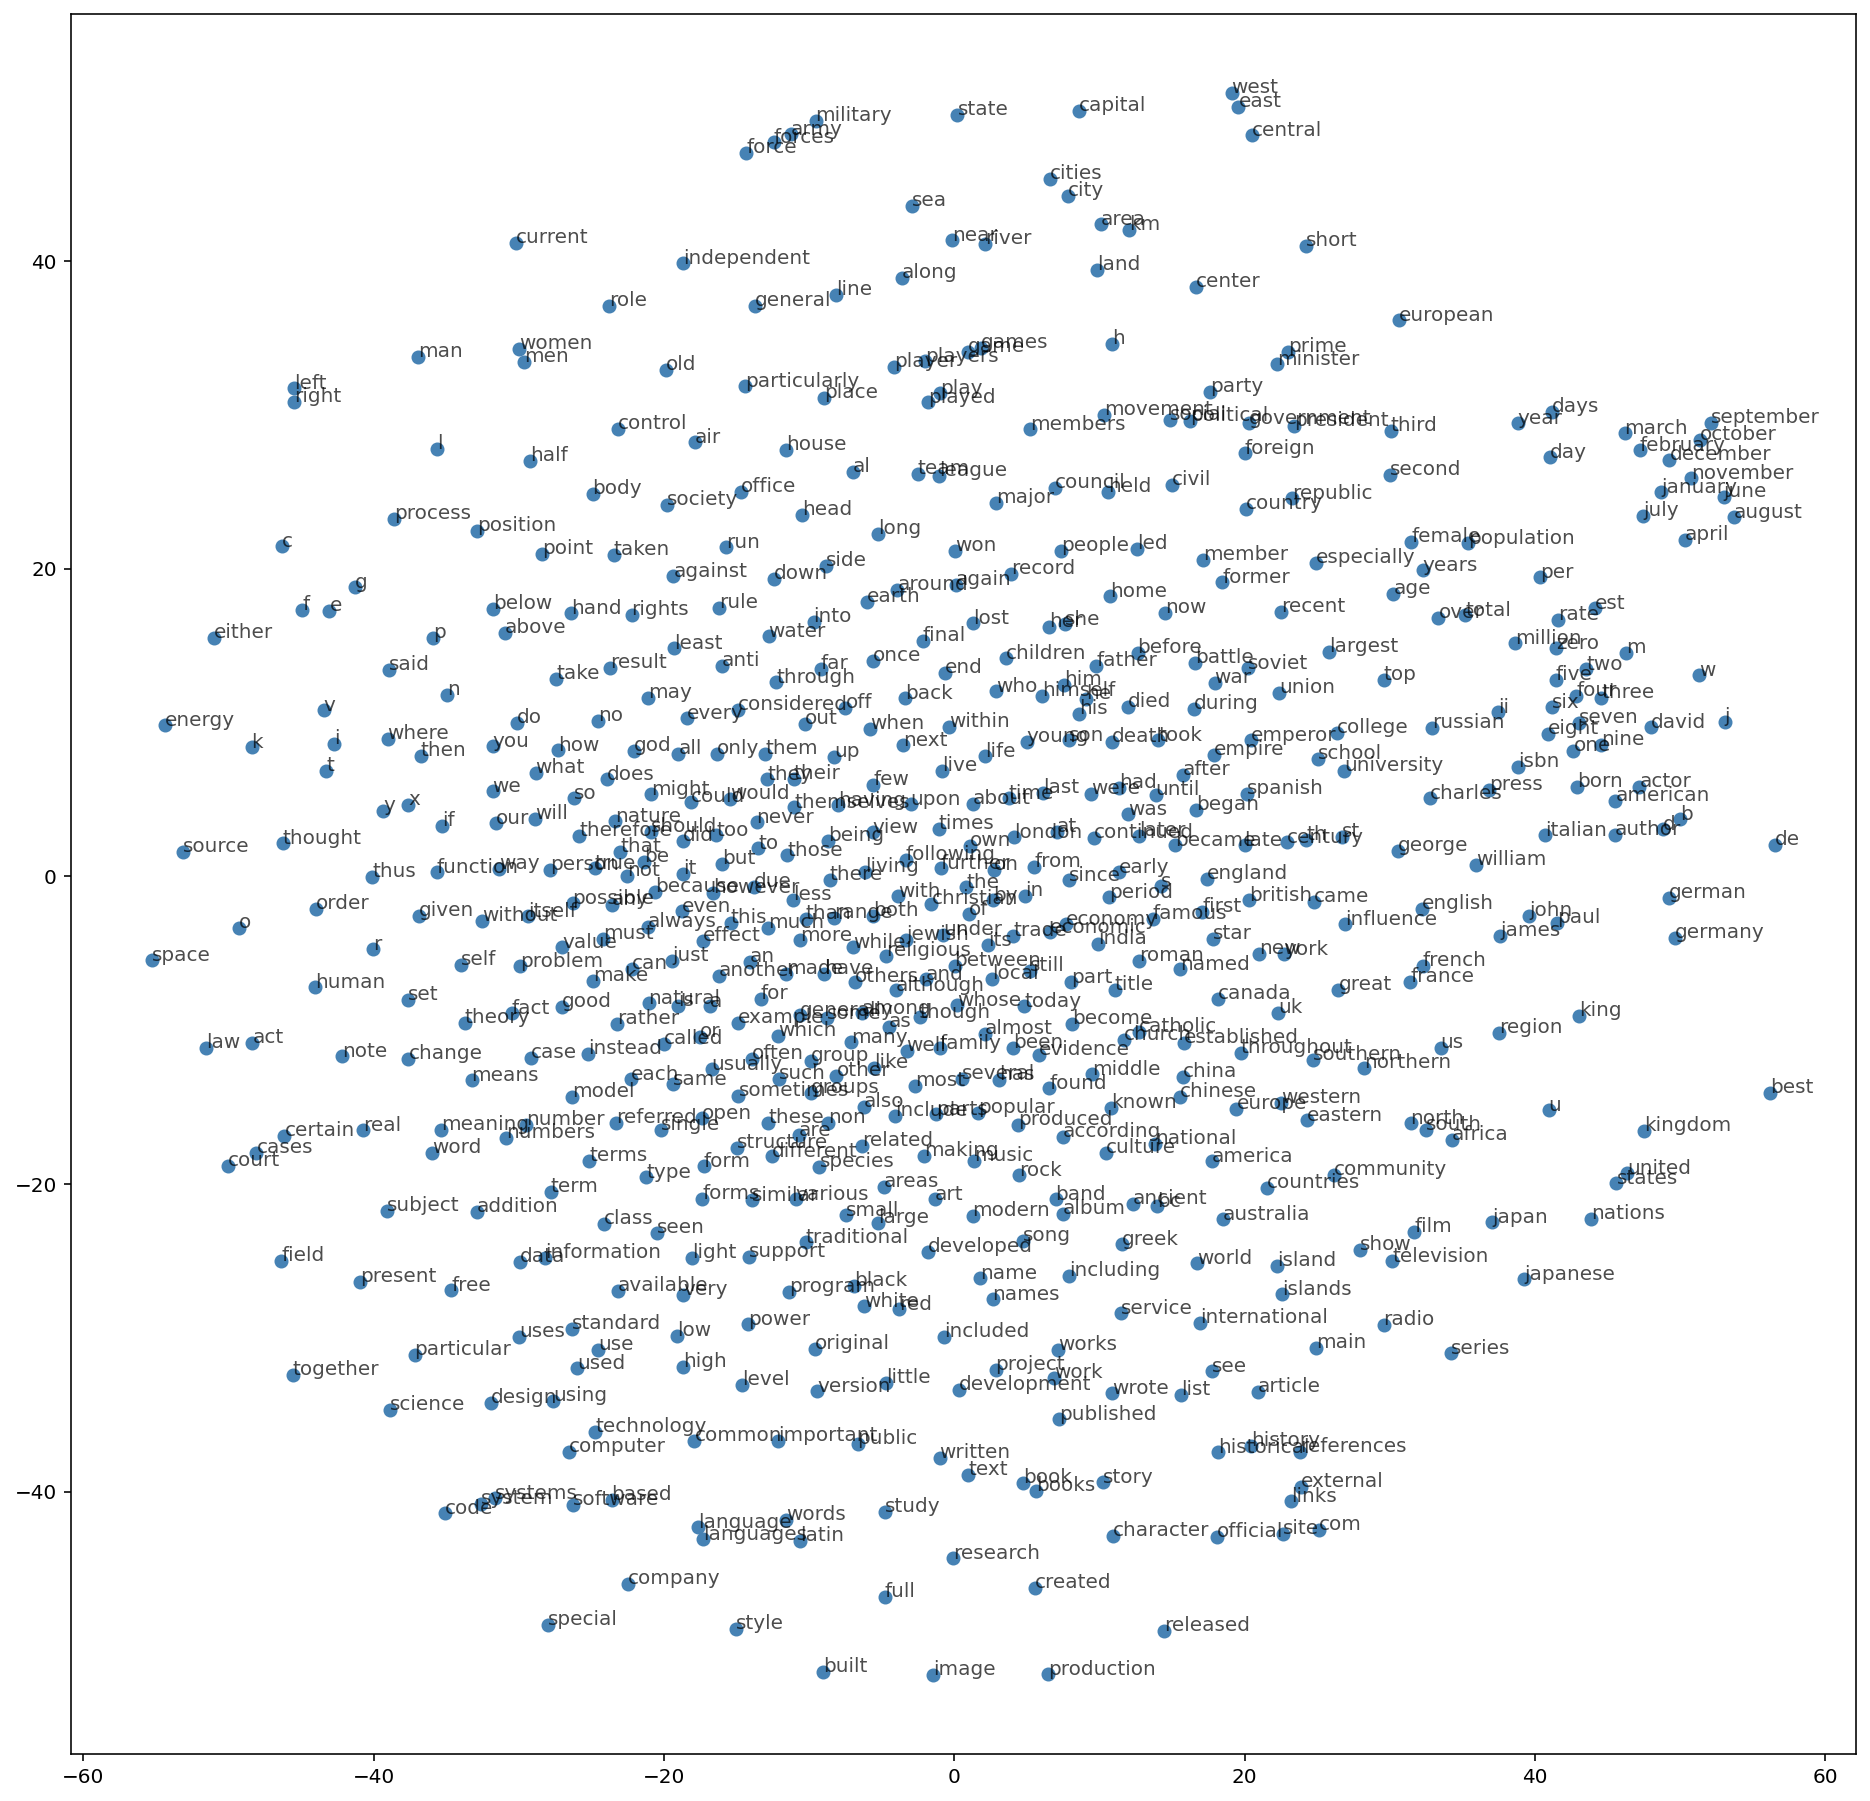

In [27]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color="steelblue")
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)